In [1]:
%load_ext Cython
import cProfile
import pandas as pd
import numpy as np
import re
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point

df = pd.read_csv('taxi.csv', index_col = 'Unnamed: 0')

In [2]:
def average_difference(month,year,dayofweek,hr,df):
    community_areas  = np.zeros(77)
    df = df.dropna()
    df = df[(df['month'] == month) & (df['year'] == year) & (df['dayofweek'] == dayofweek) & (df['hour'] == hr+1)]
    missing_ca = [i for i in range(1,78) if i not in df['pickup_community_area'].values]
        
    for i in missing_ca:
        df = df.append(pd.Series([0,month, year, dayofweek,hr,i], index=df.columns), ignore_index=True)
        
    for i in df['pickup_community_area'].values:
        diff_sum = 0
        record = df[df['pickup_community_area'] == i]
        
        for j in df['pickup_community_area'].values:
            diff_sum += record['count(1)'].values[0] - df[df['pickup_community_area'] == j]['count(1)'].values[0] 
        
        community_areas[int(i-1)] = diff_sum/77
        
    return community_areas
        

In [3]:
def twentyfourhr(month,year,dayofweek,df):
    day = np.zeros((24,77))
    for hr in range(0,24): 
        day[hr] = average_difference(month,year,dayofweek,hr,df) 
    return day

In [4]:
cProfile.run('twentyfourhr(3,2017,4,df)')

         198006444 function calls (195965876 primitive calls) in 277.180 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   289196    0.442    0.000    0.647    0.000 <frozen importlib._bootstrap>:416(parent)
  1748700    1.018    0.000    3.534    0.000 <frozen importlib._bootstrap>:997(_handle_fromlist)
       24    3.845    0.160  277.180   11.549 <ipython-input-2-05f00ac16e0f>:1(average_difference)
       24    0.024    0.001    0.050    0.002 <ipython-input-2-05f00ac16e0f>:5(<listcomp>)
        1    0.001    0.001  277.180  277.180 <ipython-input-3-5917fe2e3c18>:1(twentyfourhr)
        1    0.000    0.000  277.180  277.180 <string>:1(<module>)
   147464    0.238    0.000    0.412    0.000 __init__.py:221(iteritems)
       24    0.000    0.000    0.000    0.000 __init__.py:227(itervalues)
        3    0.000    0.000    0.000    0.000 _collections_abc.py:252(__subclasshook__)
        2    0.000    0.000    0.000    0.000

      812    0.011    0.000    0.234    0.000 concat.py:486(_concat_index_asobject)
      812    0.001    0.000    0.009    0.000 concat.py:496(<listcomp>)
      812    0.002    0.000    0.003    0.000 concat.py:503(<listcomp>)
      812    0.001    0.000    0.001    0.000 concat.py:507(<listcomp>)
     2436    0.002    0.000    0.007    0.000 concat.py:510(<genexpr>)
      812    0.006    0.000    0.033    0.000 concat.py:84(_get_frame_result_type)
     1624    0.002    0.000    0.010    0.000 concat.py:92(<genexpr>)
     1624    0.001    0.000    0.010    0.000 concat.py:93(<genexpr>)
     1624    0.001    0.000    0.005    0.000 concat.py:97(<genexpr>)
      836    0.012    0.000    0.309    0.000 construction.py:106(init_ndarray)
      836    0.002    0.000    0.004    0.000 construction.py:217(prep_ndarray)
      836    0.003    0.000    0.032    0.000 construction.py:363(_get_axes)
   145172    1.645    0.000   19.899    0.000 construction.py:537(sanitize_array)
   144360    0.99

      144    0.001    0.000    0.047    0.000 series.py:3831(fillna)
   436260    0.735    0.000    1.474    0.000 series.py:392(name)
   290084    0.672    0.000    1.003    0.000 series.py:399(name)
  1586760    1.289    0.000    3.956    0.000 series.py:406(dtype)
   289268    0.337    0.000    1.057    0.000 series.py:434(values)
   144192    0.182    0.000    0.510    0.000 series.py:476(_values)
   144264    0.160    0.000    0.988    0.000 series.py:490(get_values)
   144980    0.102    0.000    0.808    0.000 series.py:591(__len__)
   144192    0.627    0.000    9.570    0.000 series.py:669(__array__)
       24    0.000    0.000    0.000    0.000 shape_base.py:209(_arrays_for_stack_dispatcher)
       24    0.000    0.000    0.000    0.000 shape_base.py:220(_warn_for_nonsequence)
       24    0.000    0.000    0.019    0.001 shape_base.py:229(vstack)
       24    0.000    0.000    0.000    0.000 shape_base.py:283(<listcomp>)
       48    0.000    0.000    0.000    0.000 shape_ba

In [8]:
%%cython
import numpy as np
cimport numpy as np
import pandas as pd

def average_difference_opt(month,year,dayofweek,hr,df):
    community_areas  = np.zeros(77)
    df = df.dropna()
    df = df[(df['month'] == month) & (df['year'] == year) & (df['dayofweek'] == dayofweek) & (df['hour'] == hr+1)]
    missing_ca = [i for i in range(1,78) if i not in df['pickup_community_area'].values]
        
    for i in missing_ca:
        df = df.append(pd.Series([0,month, year, dayofweek,hr,i], index=df.columns), ignore_index=True)
        
    for i in df['pickup_community_area'].values:
        diff_sum = 0
        record = df[df['pickup_community_area'] == i]
        
        for j in df['pickup_community_area'].values:
            diff_sum += record['count(1)'].values[0] - df[df['pickup_community_area'] == j]['count(1)'].values[0] 
        
        community_areas[int(i-1)] = diff_sum/77
        
    return community_areas

In [9]:
def twentyfourhr_opt(month,year,dayofweek,df):
    day = np.zeros((24,77))
    for hr in range(0,24): 
        day[hr] = average_difference_opt(month,year,dayofweek,hr,df) 
    return day

In [10]:
cProfile.run('twentyfourhr_opt(3,2017,4,df)')

         198004054 function calls (195964246 primitive calls) in 245.943 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   289196    0.416    0.000    0.604    0.000 <frozen importlib._bootstrap>:416(parent)
  1748700    0.919    0.000    3.100    0.000 <frozen importlib._bootstrap>:997(_handle_fromlist)
        1    0.000    0.000  245.943  245.943 <ipython-input-9-5e1c3284cb3a>:1(twentyfourhr_opt)
        1    0.000    0.000  245.943  245.943 <string>:1(<module>)
   147464    0.217    0.000    0.372    0.000 __init__.py:221(iteritems)
       24    0.000    0.000    0.000    0.000 __init__.py:227(itervalues)
  1159557    3.417    0.000    8.866    0.000 _dtype.py:319(_name_get)
   291704    1.078    0.000    2.968    0.000 _dtype.py:46(__str__)
      812    0.003    0.000    0.003    0.000 _internal.py:886(npy_ctypes_check)
       48    0.000    0.000    0.535    0.011 _methods.py:34(_sum)
   723468    0.477    0.000    4

       24    0.001    0.000    1.950    0.081 frame.py:7384(_reduce)
       24    0.000    0.000    1.937    0.081 frame.py:7395(f)
       24    0.000    0.000    0.000    0.000 frame.py:7600(_get_agg_axis)
       24    0.000    0.000    0.003    0.000 fromnumeric.py:2083(any)
       24    0.000    0.000    0.001    0.000 fromnumeric.py:54(_wrapfunc)
       24    0.000    0.000    0.003    0.000 fromnumeric.py:69(_wrapreduction)
       24    0.000    0.000    0.000    0.000 fromnumeric.py:70(<dictcomp>)
       24    0.000    0.000    0.001    0.000 fromnumeric.py:942(argsort)
       24    0.000    0.000    0.000    0.000 function.py:40(__call__)
       24    0.000    0.000    1.950    0.081 generic.py:10910(stat_func)
   436448    1.619    0.000    1.619    0.000 generic.py:127(__init__)
   145840    0.278    0.000    0.325    0.000 generic.py:144(_init_mgr)
       24    0.000    0.000    0.089    0.004 generic.py:1463(__invert__)
   144264    0.218    0.000   11.181    0.000 generic.p

       24    0.000    0.000    0.001    0.000 {built-in method builtins.sorted}
   148276    0.235    0.000    0.698    0.000 {built-in method builtins.sum}
   291752    0.787    0.000    0.787    0.000 {built-in method numpy.arange}
1595575/1307191    4.590    0.000   12.258    0.000 {built-in method numpy.array}
     2484    0.045    0.000    0.045    0.000 {built-in method numpy.concatenate}
   582596    1.502    0.000    1.502    0.000 {built-in method numpy.empty}
  1154400    0.337    0.000    0.337    0.000 {built-in method numpy.geterrobj}
       24    0.217    0.009    0.217    0.009 {built-in method numpy.putmask}
   577200    0.577    0.000    0.577    0.000 {built-in method numpy.seterrobj}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
   288552    0.304    0.000    0.304    0.000 {built-in method pandas._libs.missing.checknull}
     6496    0.002    0.000    0.002    0.000 {method 'add' of 'set' objects}
      812    0.002    0.000    0.012   

In [11]:
avg_diff = twentyfourhr(3,2017,4,df)

In [12]:
cahp = gpd.read_file('./Boundaries - Community Areas (current)/geo_export_a30146d3-7df1-499d-84f7-c7fef58a4030.shp')
geo_df = pd.DataFrame(cahp)
geo_df['area_num_1'] = geo_df['area_num_1'].astype(float)

In [13]:
for i in range(0,24): 
    hr = pd.DataFrame({str(i+1) + 'hr' : avg_diff[i,:]})
    hr['community_area'] = hr.index.values + 1
    geo_df = pd.merge(hr,geo_df, left_on = 'community_area', right_on = 'area_num_1')
    geo_df.drop('community_area', inplace=True, axis=1)
    


In [14]:
columns = ['area','comarea','comarea_id','perimeter']
geo_df.drop(columns, inplace=True, axis=1)

max_val = max([geo_df.loc[geo_df[str(i)+'hr'].idxmax()][str(i)+'hr'] for i in range(1,25)])
min_val = min([geo_df.loc[geo_df[str(i)+'hr'].idxmin()][str(i)+'hr'] for i in range(1,25)])

In [15]:
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(geo_df, crs=crs, geometry=geo_df.geometry)

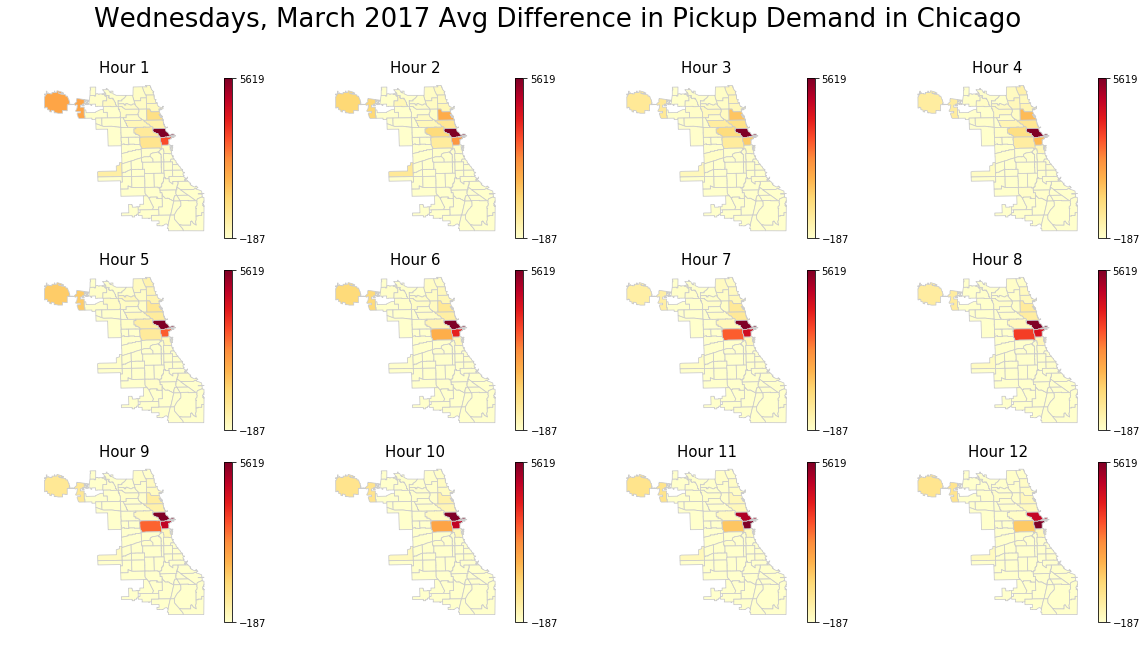

In [19]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
counter = 1
for row in range(0,3):
    for item in range(0,4):
        gdf.plot(column=str(counter)+'hr', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', ax = ax.flat[counter-1])
        # set the range for the choropleth
        vmin, vmax = min_val, max_val
        ax[row,item].axis('off')
        ax[row, item].set_title('Hour '+str(counter),fontsize=15)
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # empty array for the data range
        sm._A = []
        # add the colorbar to the figure
        cbar = fig.colorbar(sm,ax=ax[row,item],ticks=[vmin, vmax])
        counter += 1

fig.suptitle("Wednesdays, March 2017 Avg Difference in Pickup Demand in Chicago",fontsize=26)
plt.show()


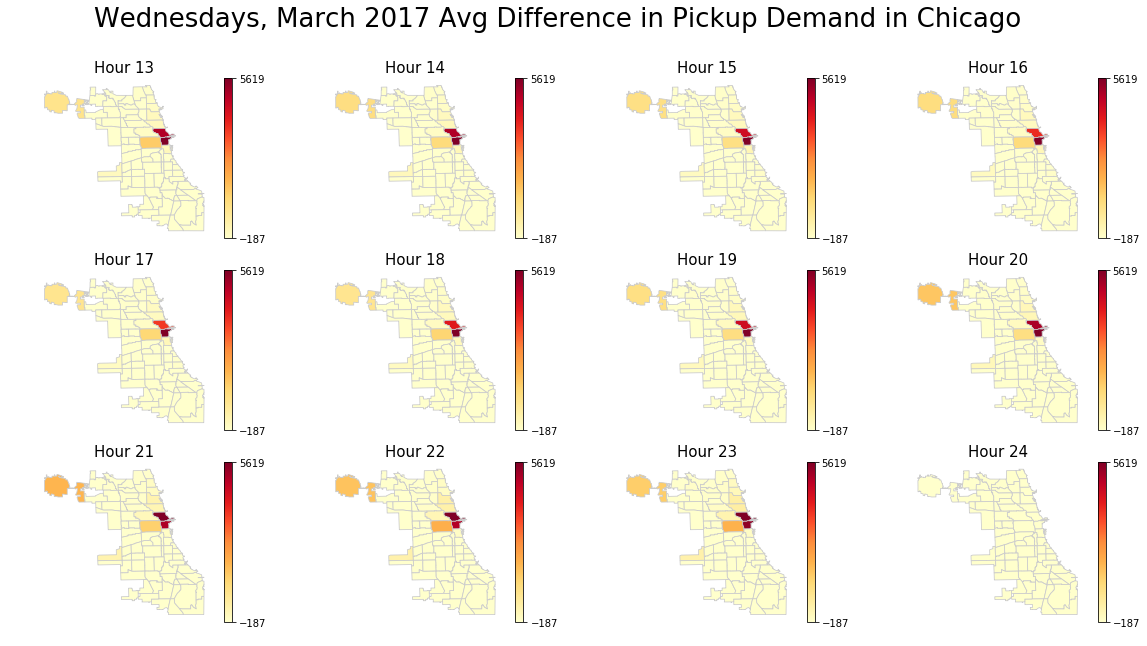

In [20]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))

for row in range(0,3):
    for item in range(0,4):
        gdf.plot(column=str(counter)+'hr', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', ax = ax.flat[counter-13])
        # set the range for the choropleth
        vmin, vmax = min_val, max_val
        ax[row,item].axis('off')
        ax[row, item].set_title('Hour '+str(counter),fontsize=15)
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # empty array for the data range
        sm._A = []
        # add the colorbar to the figure
        cbar = fig.colorbar(sm,ax=ax[row,item],ticks=[vmin, vmax])
        counter += 1

fig.suptitle("Wednesdays, March 2017 Avg Difference in Pickup Demand in Chicago",fontsize=26)
plt.show()